In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output
from PIL import Image

In [2]:
model_handle = 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
hub_model = hub.load(model_handle)

In [3]:
cap = cv2.VideoCapture("D:\\MLProjects\\parking\\videos\\park.mp4")
area = [(381, 104), (342, 125), (599, 192), (597, 151)]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 30.0, (1020, 500))


In [4]:
count = 0


In [5]:
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32) * 0.03
kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.01


In [6]:
tracked_positions = []
tracked_ids = []


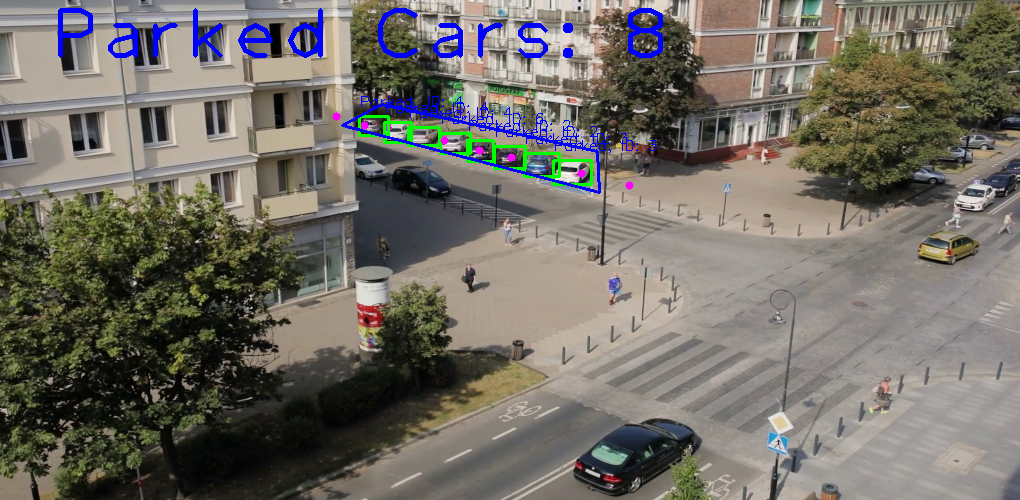

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        break
    count += 1

    if count % 3 != 0:
        continue
    if frame is None or frame.shape[0] == 0 or frame.shape[1] == 0:
        continue
    frame = cv2.resize(frame, (1020, 500))

    image_tensor = tf.convert_to_tensor(frame)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    results = hub_model(image_tensor)

    image_with_detections = frame.copy()
    detection_boxes = results["detection_boxes"][0].numpy()
    detection_classes = results["detection_classes"][0].numpy().astype(int)
    detection_scores = results["detection_scores"][0].numpy()

    for i in range(len(detection_boxes)):
        if detection_scores[i] >= 0.5:
            ymin, xmin, ymax, xmax = detection_boxes[i]
            xmin, xmax, ymin, ymax = int(xmin * 1020), int(xmax * 1020), int(ymin * 500), int(ymax * 500)

            cx = (xmin + xmax) // 2
            cy = (ymin + ymax) // 2
            results = cv2.pointPolygonTest(np.array(area, np.int32), ((cx, cy)), False)

            if results >= 0:
                kalman.correct(np.array([[cx], [cy]], np.float32))
                kalman_prediction = kalman.predict()
                kalman_cx, kalman_cy = int(kalman_prediction[0]), int(kalman_prediction[1])

                is_parked = False
                if len(tracked_positions) > 0:
                    for tracked_pos, tracked_id in zip(tracked_positions, tracked_ids):
                        if np.linalg.norm(np.array([kalman_cx, kalman_cy]) - tracked_pos) < 50:
                            is_parked = True
                            break

                # Drawing boxes only around parked cars
                if is_parked:
                    cv2.rectangle(image_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                    cv2.circle(image_with_detections, (kalman_cx, kalman_cy), 4, (255, 0, 255), -1)
                    cv2.putText(
                        image_with_detections,
                        f"Parked, ID: {tracked_id}",
                        (xmin, ymin - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0),
                        1,
                    )
                    tracked_positions[tracked_ids.index(tracked_id)] = np.array([kalman_cx, kalman_cy])
                else:
                    tracked_positions.append(np.array([kalman_cx, kalman_cy]))
                    tracked_ids.append(len(tracked_ids) + 1)

    cv2.polylines(image_with_detections, [np.array(area, np.int32)], True, (255, 0, 2), 2)
    k = len(tracked_ids)
    cv2.putText(image_with_detections, f"Parked Cars: {k}", (50, 60), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 3)

    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB)))
    out.write(image_with_detections)

    if cv2.waitKey(1) & 0xFF == 27:
        break

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()